In [9]:
# mwr 20170910
# Spectral 1D test
# Skin effect in slab geometry, preparation for wire

import time
from numpy import *
import matplotlib.pyplot as plt
import numpy.polynomial.chebyshev
import numpy.linalg

# Default color map
plt.rcParams['image.cmap'] = 'jet'

# Our Chebyshev package
from cheby import chebybasis, chebyfit1, chebyder1

In [10]:
# Define fields
# Names suitable for variables
wnames = ['by','ete']
# TeX names with escaped escapes
wtex = ['B_y','e_{th}']

# Number of fields
nw = size(wnames)

In [11]:
# Generate indexing variables like rho_ = 1, vr_ = 2, etc. that
# can be used in expressions like w[...,rho_]

for iw in range(nw):
    cmd = '%s_\t= %d' % (wnames[iw], iw)
    print(cmd)
    exec(cmd)

by_	= 0
ete_	= 1


In [12]:
# Mesh size (tuple of dimensions for compatibility with mutli-dimensional code)
nx = (33,)

In [13]:
nx1 = nx[0]

# Notation problem rearing is ugly head, first dimension is nx1 but also nx[0]

In [14]:
# Set up Chebyshev coordinate x1 (-1 <= x1 <= +1)

# Maximum number of terms in Chebyshev series
ncmax = nx1

# Number of terms we actually use
nc = ncmax

# Get a basis for nx1 points to size nc
T,dTdx,x1 = chebybasis(nx1,nc)[:3]

# Inverse for faster computation
Tinv = numpy.linalg.inv(T)

In [15]:
# Shape of c is (nx1,...)

# Routines for val (series summation) in different directions
val1 = lambda c: tensordot(T, c, (1,0))

# Routines for fit (coefficient determination) in different directions
fit1 = lambda f: tensordot(Tinv, f, (1,0))

# All directions sum giving real result
val = lambda c: val1(c)

# All directions fit
fit = lambda f: fit1(f)

In [16]:
xmin = -1
xmax = 1

# Mesh coordinate array assuming xmin=-1 and xmax=+1
mx = x1

print((xmin,xmax))
print((mx[0],mx[-1]))

(-1, 1)
(-1.0, 1.0)


In [17]:
# Diffusion constant (n.b., elsewhere hard coded for D=1)
D = 1

# Thermal diffusion (alpha << D)
alpha = 1e-3

print('Diffusion constant:', D)
print('Thermal diffusivity:', alpha)

# Like VAC we define a diffusive stability paramter
dtdiffpar = 0.5

# Estimate stability time step
print('dtdiffpar:', dtdiffpar)
print('Estimated stable time step:', dtdiffpar*(mx[1] - mx[0])**2/D)

Diffusion constant: 1
Thermal diffusivity: 0.001
dtdiffpar: 0.5
Estimated stable time step: 1.15934286107e-05


In [18]:
# Set up initial state
wini = zeros(nx+(nw,))

# Value at end points
wini[0,by_] = -1
wini[-1,by_] = 1

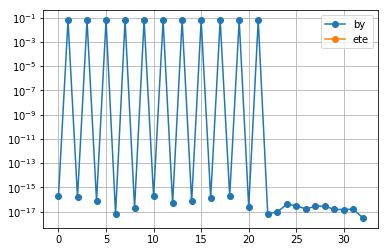

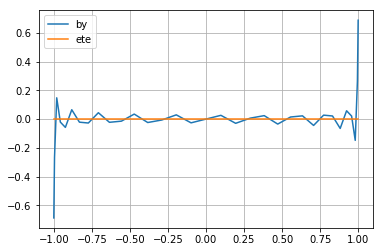

In [19]:
# 2/3 rule cleanup
def rule23(w):
    cw = fit(w)
    cw[2*nc//3:] = 0
    w = val(cw)
    return w

wini = rule23(wini)

plt.semilogy(abs(fit(wini)),'o-')
plt.grid()
if size(wnames)>1:
    plt.legend(wnames)
else:
    plt.ylabel('$c_{%s}$' % wtex[0], FontSize=16)
plt.show()

plt.plot(mx,wini)
plt.grid()
if size(wnames)>1:
    plt.legend(wnames)
else:
    plt.ylabel('$%s$' % wtex[0], FontSize=16)
plt.show()


In [20]:
# Sampling coordinates for diagnostic plots

ixtest = nx1 - 3
print('ixtest:',ixtest)

ixtest: 30


In [21]:
# Derivative operators take coefficient array as argument

# Array c is of shape (nx1,...)

# To calculate coefficients of derivatives in different directions
der1matrix = matmul(Tinv, dTdx)
der1 = lambda c: tensordot(der1matrix, c, (1,0))

In [22]:
# Functions to undo the w=stack((a,b,...),axis=-1) python operation

# Function views produces views into the last-index slices of array w
# Can be called with (a,b,...) = views(w)
views = lambda w: tuple([w[...,i] for i in arange(shape(w)[-1])])

# Function destack produces new arrays that can be modified without affecting w
destack = lambda w: tuple([w[...,i].copy() for i in arange(shape(w)[-1])])

In [23]:
# Scale factors
h1 = (xmax - xmin)/2

# Derivative functions 
# (create coefficients of derivative from coefficients of function)
ddx = lambda c: der1(c)/h1


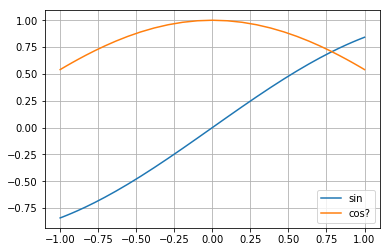

In [24]:
# Test the differentiation operator
f = sin(mx)
dfdx = val(ddx(fit(f)))

plt.plot(mx, f, mx, dfdx)
plt.grid()
plt.legend(('sin','cos?'))
plt.show()

In [25]:
def cquadc(c):
    "Function to integrate a Chebyshev series given coefficients"
    q = 2*c[0]
    for i in range(2,size(c,0),2):
        q = q - 2*c[i]/((i+1)*(i-1))
    return q

In [26]:
# Volume element for integrals

# The volume element is constant as a function of Chebyshev coordinate

dV = h1*ones_like(mx)


In [27]:
quadc = lambda c: cquadc(c)

quad = lambda f: quadc(fit(f))

def f_flux(w):
    "Compute total magnetic flux"
    # Get views into field array w
    (by,ete) = views(w)
    # Total flux (change to area)
    mass = quad(by*dV)
    return mass


def f_E(w):
    "Compute total thermal energy"
    # Get views into field array w
    (by,ete) = views(w)
    # Total thermal energy
    mass2 = quad(ete*dV)
    return mass2


In [28]:
print('        volume:',quad(dV))
print(' (theoretical):',xmax - xmin)
print('          flux:',f_flux(wini))
print(' (theoretical):',0*(xmax - xmin))
print('         E:', f_E(wini))
print(' (theoretical):', 0)


        volume: 2.0
 (theoretical): 2
          flux: 4.98441141364e-16
 (theoretical): 0
         E: 0.0
 (theoretical): 0


In [29]:
# PDE in Eulerian form
# The stack is (by,ete)

global ncall_eulerianpde
ncall_eulerianpde = 0

def eulerianpde(w, t, cw=None):
    global ncall_eulerianpde
    ncall_eulerianpde += 1
    if cw is None:
        # Basis function coefficients
        cw = fit(w)
    # Get views into the w and cw arrays
    # Notation: c prefix denotes basis function coefficients
    # For clarity we drop the m prefix from mesh values
    (by,ete) = views(w)
    (cby,cete) = views(cw)
    # Coefficent for current
    cJ = ddx(cby)
    # Heat flux with BC
    q = val(ddx(cete))
    q[[0,-1]] = 0
    # PDE
    by_t = val(ddx(cJ))
    ete_t = val(cJ)**2 + (alpha/D)*val(ddx(fit(q)))
    # Boundary condition on derivatives
    by_t[[0,-1]] = 0
    # Return result array
    return stack((by_t,ete_t),axis=-1)


In [30]:
# Boundary conditions for function and time-derivative

def bc(w):
    "Apply boundary conditions to argument array"
    w[0,by_] = -1
    w[-1,by_] = 1
    

In [31]:
# Initial conditions

# Take a copy of the initial conditions
# In Python, if we did w = wini then w and wini would be the SAME array
# and evolving the matrix elements of w would also alter those of wini
# (this is different from MATLAB where the expression w = wini makes a copy)
w = wini.copy()

In [32]:
# Calculate Eulerian time derivatives
w_t = eulerianpde(w, 0)

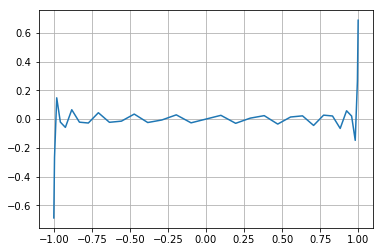

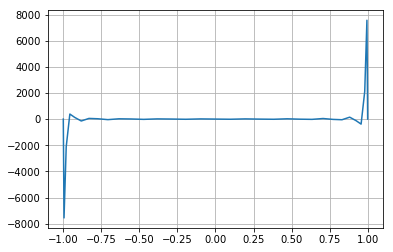

In [33]:
iw = by_

plt.plot(mx,w[:,iw])
plt.grid()
plt.show()

plt.plot(mx,w_t[:,iw])
plt.grid()
plt.show()

In [34]:
#print('thermal energy:',f_E_th(w))
#print('kinetic energy:',f_E_kin(w))

In [35]:
# Function to plot Eulerian time derivatives

def plot_eulerian_time_derivative(w_t, iw):
    # First subplot: plot against first index
    plt.subplot(1, 2, 1)
    plt.plot(w_t[...,iw])
    plt.ylabel('$\partial %s/\partial t$' % wtex[iw], FontSize=16)
    plt.xlabel('ix1')
    plt.xlim((0,nx1-1))
    common_ylim=plt.ylim()
    # Second subplot: plot against second index, same y limits
    plt.subplot(1, 2, 2)
    plt.plot(w_t[...,iw].T)
    plt.xlabel('ix2')    
    plt.ylim(common_ylim)
    plt.xlim((0,nx2-1))
    # Declutter by suppressing y tick values (here we just suppress the y axis,
    # could be better by leaving ticks somehow)
    ax = plt.gca()
    ax.yaxis.set_visible(False)
    plt.show()

def plot_eulerian_time_derivatives(w_t):
    for iw in range(nw):
        plot_eulerian_time_derivative(w_t, iw)
        
#plot_eulerian_time_derivatives(w_t)


In [36]:
# Function to make plot during evolution

def doframe():
    global iframe
    iw = by_
    plt.plot(w[...,iw].T)
    plt.ylabel('$%s$' % wtex[iw], FontSize=16)
    plt.title('t(%d) = %g' % (it,t))
    plt.grid()
    plt.ylim(-1.1, 1.1)
    #plt.show()
    iframe = iframe + 1
    plt.show()
    #plt.savefig('movie-p/frames/p%03d.png' % iframe)
    #plt.close()
  
# Uncomment to redefine doframe to suppress plot generation:
def doframe(): print('frame suppressed it = %d, t = %g' % (it,t))


In [37]:
# A period of Eulerian evolution

# Initialize t and w
t = 0
w = wini.copy()

# Time step for one iteration
dt = 1e-5

# Number of iterations (time steps)
itmax = 6000

# Make a movie frame every ditframe iterations
ditframe = 100

# Initialize frame index
iframe = 0

# Make a snapshot every ditsave iterations
ditsave = 10

# We will save a series of snapshots in ts and ws
# Initialize as empty tuples
ts = ()
ws = ()

# History
v_t = zeros(itmax + 1)
v_E = zeros(itmax + 1)

# Time advance method
method = 'onestep'
#method = 'twostep'
#method = 'rk4'

fun = eulerianpde

clock0 = time.clock()

for it in range(itmax + 1):
    # Boundary conditions
    bc(w)
    #w = rule23(w)
    # Save diagnostic information
    v_t[it] = t
    v_E[it] = f_E(w)
    # Make frame every ditframe iterations
    if it % ditframe == 0:
        doframe()
    # Save snapshot every ditsave iterations
    if it % ditsave == 0:
        ts = ts + (t,)
        ws = ws + (w.copy(),)
    # Iteration itmax is a save-only
    if it == itmax:
        break
    # Advance solution one time step
    if method == 'onestep':
        # Forward Euler step
        w_t = fun(w, t)
        w = w + dt*w_t
        t = t + dt
    elif method == 'twostep':
        # Predictor-corrector step
        w_t = fun(w, t)
        w1 = w + 0.5*dt*w_t
        w_t = fun(w1, t + dt/2)
        w = w + dt*w_t
        t = t + dt
    elif method == 'rk3':
        # Third-order Runge-Kutta step
        wk1 = dt*fun(w, t)
        wk2 = dt*fun(w + wk1/2, t + dt/2)
        wk3 = dt*fun(w - wk1 + 2*wk2, t + dt)
        w = w + (wk1 + 4*wk2 + wk3)/6
        t = t + dt
    elif method == 'rk4':
        wk1 = dt*fun(w, t)
        wk2 = dt*fun(w + wk1/2, t + dt/2)
        wk3 = dt*fun(w + wk2/2, t + dt/2)
        wk4 = dt*fun(w + wk3, t + dt)
        w = w + (wk1 + 2*wk2 + 2*wk3 + wk4)/6
        t = t + dt
    else:
        raise ValueError('Unknown method: %s' % method)
        
print('Finished with t = %g' % t)
print('Wall time consumed: %.3f seconds' % (time.clock()-clock0))

frame suppressed it = 0, t = 0
frame suppressed it = 100, t = 0.001
frame suppressed it = 200, t = 0.002
frame suppressed it = 300, t = 0.003
frame suppressed it = 400, t = 0.004
frame suppressed it = 500, t = 0.005
frame suppressed it = 600, t = 0.006
frame suppressed it = 700, t = 0.007
frame suppressed it = 800, t = 0.008
frame suppressed it = 900, t = 0.009
frame suppressed it = 1000, t = 0.01
frame suppressed it = 1100, t = 0.011
frame suppressed it = 1200, t = 0.012
frame suppressed it = 1300, t = 0.013
frame suppressed it = 1400, t = 0.014
frame suppressed it = 1500, t = 0.015
frame suppressed it = 1600, t = 0.016
frame suppressed it = 1700, t = 0.017
frame suppressed it = 1800, t = 0.018
frame suppressed it = 1900, t = 0.019
frame suppressed it = 2000, t = 0.02
frame suppressed it = 2100, t = 0.021
frame suppressed it = 2200, t = 0.022
frame suppressed it = 2300, t = 0.023
frame suppressed it = 2400, t = 0.024
frame suppressed it = 2500, t = 0.025
frame suppressed it = 2600, t 

In [38]:
from scipy.special import erf
print(erf(1))

0.84270079295


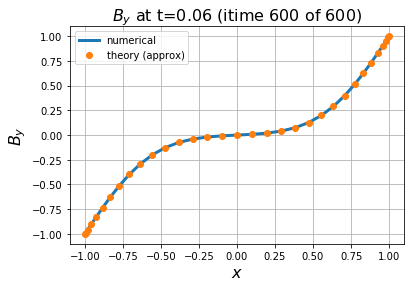

In [39]:
# Plot of  magnetic field

itime = -1
iw = by_

def plotit(iw,itime):
    plt.plot(mx,ws[itime][...,iw], LineWidth=3)
    if iw == by_:
        # Approximate solution (actually an infinite sum of erf, these are the first 2 terms)
        t = ts[itime]+spacing(1)
        plt.plot(mx,erf((mx+1)/sqrt(4*t))+erf((mx-1)/sqrt(4*t)),'o')
        plt.legend(('numerical','theory (approx)'))
        plt.ylim((-1.1,1.1))
    if iw == ete_:
        expected = (1/pi)*log(2*D/alpha) 
        plt.axhline(expected, Color='red')
        plt.ylim((0,3))        
    plt.xlabel('$x$',fontsize=16)
    plt.ylabel('$%s$' % wtex[iw],FontSize=16)
    plt.title('$%s$ at t=%g (itime %d of %d)' % (wtex[iw],ts[itime],itime % size(ts),size(ts) - 1),fontsize=16)
    plt.grid()

plotit(iw,itime)
plt.show()

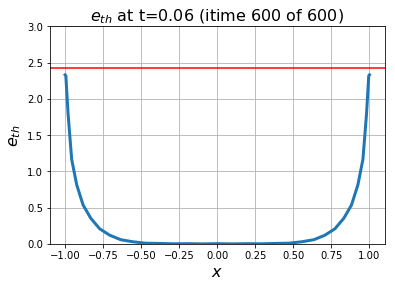

In [40]:
# Plot of temperature
itime=-1
iw = ete_
plotit(iw,itime)
plt.show()

In [41]:
def make_movie(moviedir,iw):
    import os
    # Create movie directory and frames subdirectory, if needed
    path=os.path.join(moviedir,'frames')
    os.makedirs(path,exist_ok=True)
    # Remove old frames
    files = os.listdir(path)
    for file in files:
        os.remove(os.path.join(path,file))
    # Make new frames
    iframe=0
    for itime in range(size(ts))[::(ditframe//ditsave)]:
        framefile = '%s/p%03d' % (path,iframe)
        print('rendering %s for itime = %d (0...%d)' % (framefile,itime,size(ts)))
        plt.figure()
        plotit(iw,itime)
        plt.savefig(framefile)
        plt.close()
        iframe = iframe + 1


In [42]:
#make_movie('movie-skin-slab', by_)

In [43]:
#make_movie('movie-skin-slab-ete', ete_)

In [44]:
# Spacetime, with time as last index (so fit can be used on it)

# Grid values
spacetime = stack(ws, axis=-1)

# Coefficients
cspacetime = fit(spacetime)


In [45]:
print(shape(stack(ts)))
print(shape(spacetime))
print(shape(spacetime[ixtest,iw,:]))

(601,)
(33, 2, 601)
(601,)


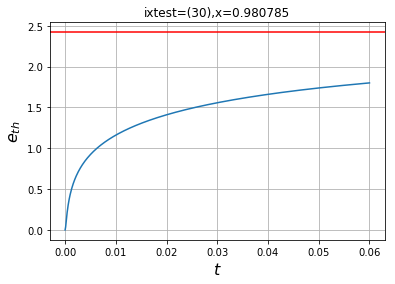

In [46]:
# Time series at a point

iw = ete_

plt.plot(stack(ts),spacetime[ixtest,iw,:])
expected = (1/pi)*log(2*D/alpha) 
plt.axhline(expected, Color='red')
plt.ylabel('$%s$' % wtex[iw], FontSize=16)
plt.xlabel('$t$', FontSize=16)
plt.title('ixtest=(%d),x=%g' % (ixtest,mx[ixtest]))
plt.grid()
plt.show()


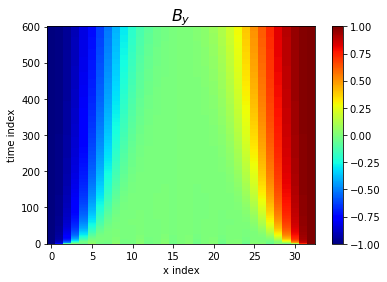

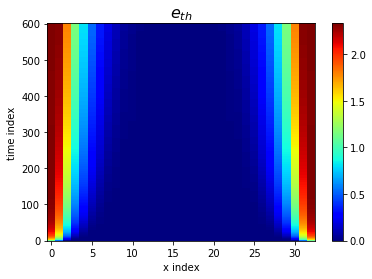

In [47]:
for iw in range(nw):
    plt.imshow(spacetime[:,iw,:].T, origin='lower',interpolation=None,aspect='auto')
    plt.title('$%s$' % wtex[iw], FontSize=16)
    plt.xlabel('x index')
    plt.ylabel('time index')
    plt.colorbar()
    plt.show()

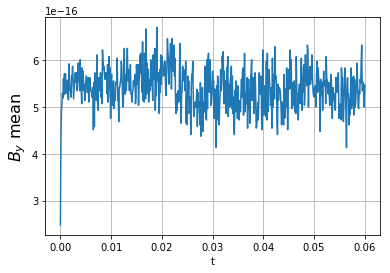

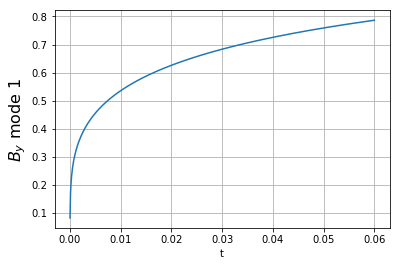

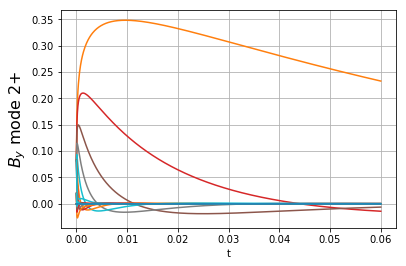

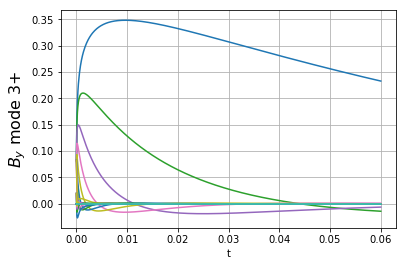

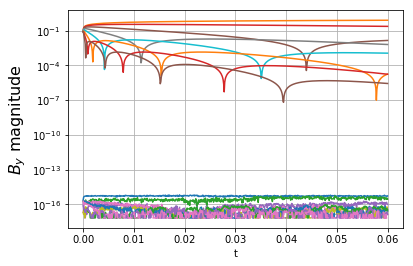

In [48]:
# Amplitude sequence

iw = by_

f=cspacetime[:,iw,:].T

plt.plot(ts,f[:,0])

plt.xlabel('t')
plt.ylabel('$%s$ mean' % wtex[iw],fontsize=16)
plt.grid()
plt.show()

plt.plot(ts,f[:,1])
plt.xlabel('t')
plt.ylabel('$%s$ mode 1' % wtex[iw],fontsize=16)
plt.grid()
plt.show()

plt.plot(ts,f[:,2:])
plt.xlabel('t')
plt.ylabel('$%s$ mode 2+' % wtex[iw],fontsize=16)
plt.grid()
plt.show()

plt.plot(ts,f[:,3:])
plt.xlabel('t')
plt.ylabel('$%s$ mode 3+' % wtex[iw],fontsize=16)
plt.grid()
plt.show()

plt.semilogy(ts,abs(f[:,:1+nx1//2]))
plt.xlabel('t')
plt.ylabel('$%s$ magnitude' % wtex[iw],fontsize=16)
plt.grid()
plt.show()

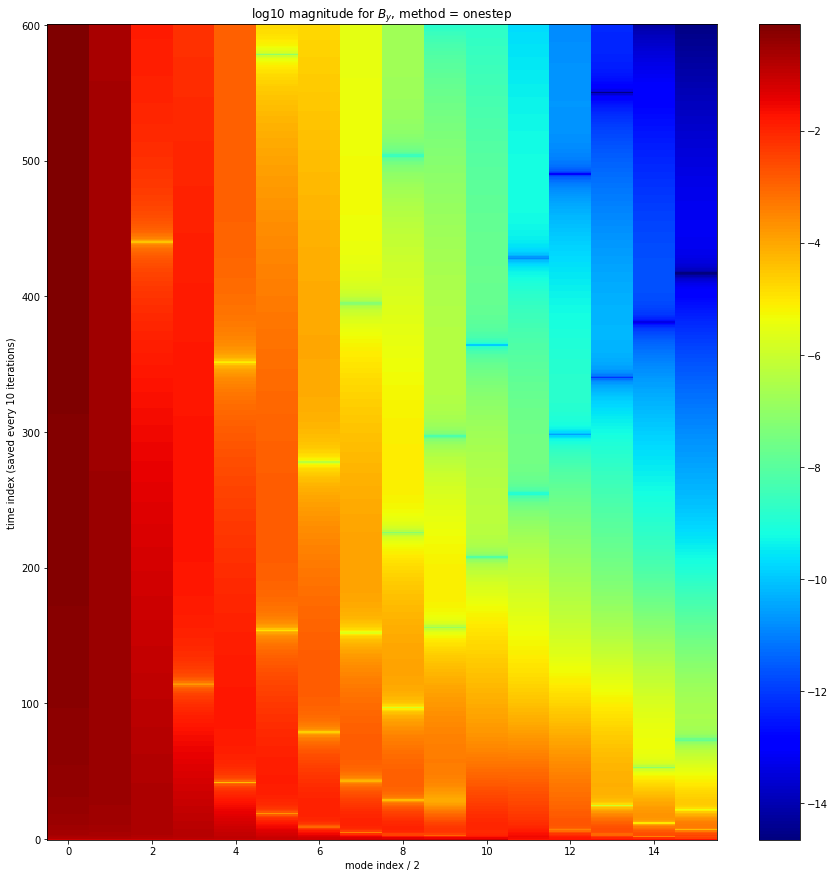

In [49]:
plt.figure(figsize=(15,15))
plt.imshow(log10(clip(abs(f[:,1::2]),1e-20,inf)),origin='lower',interpolation=None,
           aspect='auto')
plt.xlabel('mode index / 2')
plt.ylabel('time index (saved every %d iterations)' % ditsave)
plt.colorbar()
plt.title('log10 magnitude for $%s$, method = %s' % (wtex[iw],method))
plt.show()

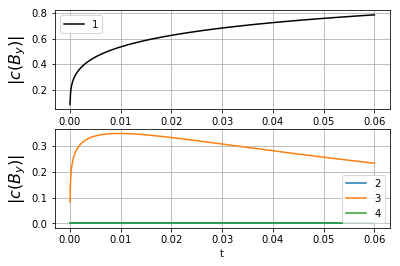

In [50]:
plt.subplot(2, 1, 1)
plt.plot(stack(ts),abs(f[:,1]),'k')
plt.ylabel('$|c(%s)|$' % wtex[iw], FontSize=16)
plt.legend(('1'))

plt.grid()
plt.subplot(2, 1, 2)

plt.plot(stack(ts),abs(f[:,2:5]))
plt.legend(('2','3','4'))
plt.xlabel('t')
plt.ylabel('$|c(%s)|$' % wtex[iw], FontSize=16)
plt.grid()

plt.show()

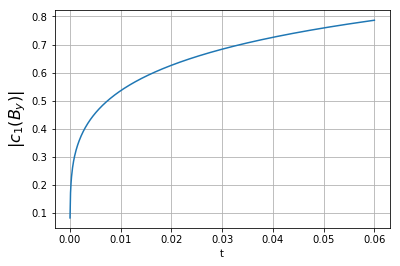

In [51]:
k=1
plt.plot(stack(ts),abs(f[:,k]))
plt.xlabel('t')
plt.ylabel('$|c_{%d}(%s)|$' % (k,wtex[iw]), FontSize=16)
plt.grid()

plt.show()

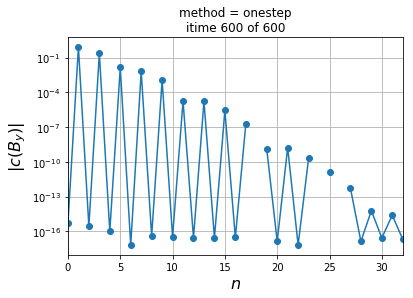

In [52]:
# Plot spectral magnitude of some field (iw) at some time (itime)
# itime = 0 is initial condition
# itime = -1 is the final time

itime = -1
iw = by_

spectralmagnitude=abs(fit(ws[itime][...,iw]))
plt.semilogy(spectralmagnitude,'o-')
plt.xlabel('$n$', FontSize=16)
plt.ylabel('$|c(%s)|$' % wtex[iw], FontSize=16)
plt.grid()
plt.xlim((0,nx1-1))
plt.title('method = %s\nitime %d of %d' % (method,itime % len(ws),len(ws) - 1))
plt.show()
